In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

from hdf5storage import savemat
from hdf5storage import loadmat
import matplotlib.patches as mpatches
import matplotlib
from matplotlib.lines import Line2D      
import hickle

import sys
sys.path.append('../src')

In [2]:
import evaluation.eval_rank as eval_rank
import evaluation.eval_utils as eval_utils

In [3]:
data_path= '/data2/data/zebrahim/synthetic_dataset/data_8192_1000_3_4_4_.03_.03_.2' + 'processed_data2.h'
with open(data_path, 'r') as fin:
    data = hickle.load(fin)
index_of_changes = data['index_of_changes']

#index of changes for test dataset
#gt_test_idx_changes = index_of_changes[900:1000]
data_num_step = 8192

In [4]:
index_of_changes.shape

(100, 4)

In [ ]:
data['train']

In [5]:
index_of_changes.shape, data['test_data'].shape

((100, 4), (100, 8192, 12))

In [6]:
CNN1001 = loadmat("../poc_synthetic/pocCNN1001"+'.mat')['poc']

NWN2001 = loadmat("../poc_synthetic/pocDWN2001"+'.mat')['poc']
NWN_NewWavelet = loadmat("../poc_synthetic/pocDWN2001_newWavelet"+'.mat')['poc']

CNN_LSTM4001 = loadmat("../poc_synthetic/pocCNN-LSTM4001"+'.mat')['poc']
WCNNRNN = loadmat("../poc_synthetic/pocWCNNRNN_synthetic_1"+'.mat')['poc']

HRNN = loadmat("../poc_synthetic/pocHRNN_synthetic_1"+'.mat')['poc']
HRNN_NewWavelet = loadmat("../poc_synthetic/pocHRNN_W2_1"+'.mat')['poc']

In [7]:
cpd_val_CNN16, cpd_CNN16 = eval_rank.non_max_supression(CNN1001, window=15, data_num_step=data_num_step)

cpd_val_NWN16, cpd_NWN16 = eval_rank.non_max_supression(NWN2001, window=15, data_num_step=data_num_step)
cpd_val_NWN16_newWavelet, cpd_NWN16_newWavelet = eval_rank.non_max_supression(NWN_NewWavelet, window=15, data_num_step=data_num_step)

cpd_val_RCNN16, cpd_RCNN16 = eval_rank.non_max_supression(CNN_LSTM4001, window=15, data_num_step=data_num_step)
cpd_val_WCNNRNN16, cpd_WCNNRNN16 = eval_rank.non_max_supression(WCNNRNN, window=15, data_num_step=data_num_step)

cpd_val_HRNN16, cpd_HRNN16 = eval_rank.non_max_supression(HRNN, window=15, data_num_step=data_num_step)
cpd_val_HRNN_NewWavelet16, cpd_HRNN_NewWavelet16 = eval_rank.non_max_supression(HRNN_NewWavelet, window=15, data_num_step=data_num_step)


In [8]:
def tolerance_auc(cpd_val, cpd, gt_mean_test, tolerance):
    out_put = []
    for t in tolerance:
        print t
        out = eval_rank.parallel_ranking(cpd_val, cpd, gt_mean_test, t)
        out_put.append(eval_utils.calc_auc(zip(out[0], out[1]), gt_mean_test))
        
    return out_put    

In [ ]:
tolerance = [8, 16, 32, 64, 128, 256, 512]
tol_auc_CNN16 = tolerance_auc(cpd_val_CNN16, cpd_CNN16, index_of_changes, tolerance)
tol_auc_NWN16 = tolerance_auc(cpd_val_NWN16, cpd_NWN16, index_of_changes, tolerance)
tol_auc_RCNN16 = tolerance_auc(cpd_val_RCNN16, cpd_RCNN16, index_of_changes, tolerance)
tol_auc_WCRNN16 = tolerance_auc(cpd_val_WCNNRNN16, cpd_WCNNRNN16, index_of_changes, tolerance)
tol_auc_HRNN16 = tolerance_auc(cpd_val_HRNN16, cpd_HRNN16, index_of_changes, tolerance)

In [ ]:
tol_auc_HRNN_NewWavelet16 = tolerance_auc(cpd_val_HRNN_NewWavelet16, cpd_HRNN_NewWavelet16, index_of_changes, tolerance)
tol_auc_NWN16_newWavelet = tolerance_auc(cpd_val_NWN16_newWavelet, cpd_NWN16_newWavelet, index_of_changes, tolerance)


'F'

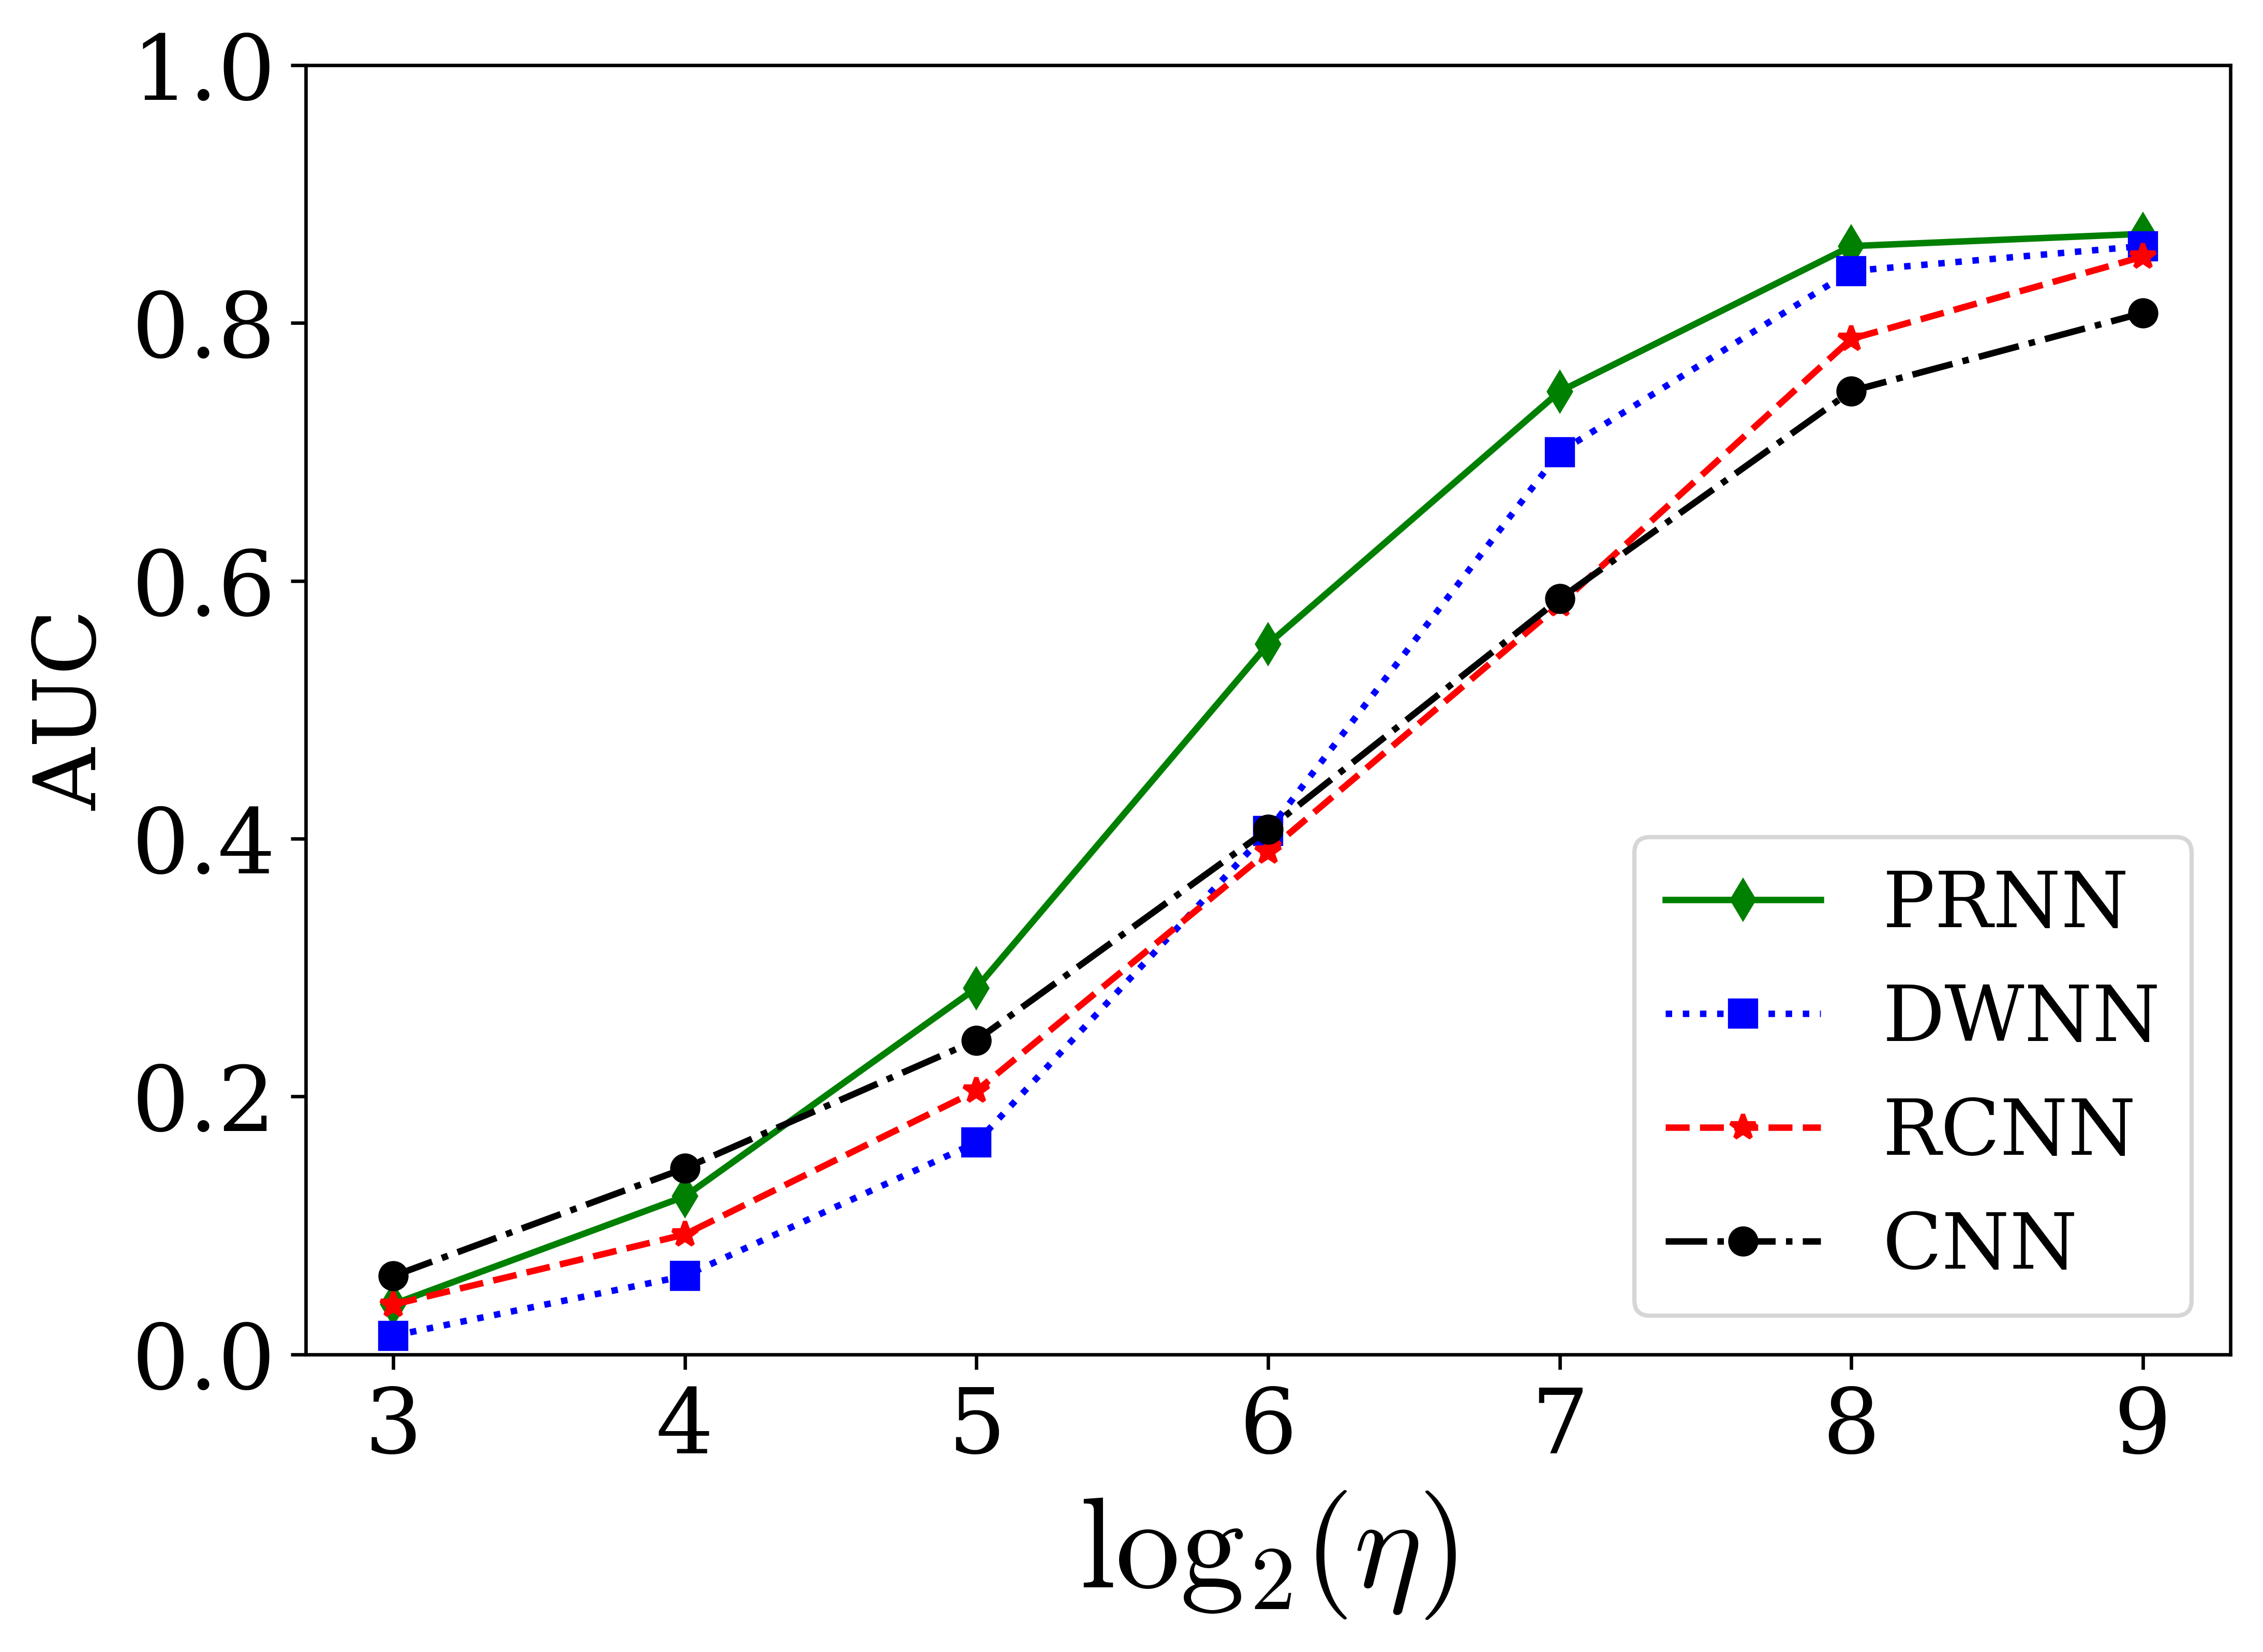

In [26]:
matplotlib.rcParams['mathtext.fontset'] = 'cm'


plt.figure(figsize=(8,5.5), dpi=600)
plt.plot(np.log2(tolerance[:]),tol_auc_HRNN16[:],'d-g',label ='PRNN')
plt.plot(np.log2(tolerance[:]),tol_auc_NWN16[:],':sb',label ='DWNN')
plt.plot(np.log2(tolerance[:]),tol_auc_RCNN16[:],'--*r',label ='RCNN')
plt.plot(np.log2(tolerance[:]),tol_auc_CNN16[:],'-.ok',label ='CNN')


#plt.plot(np.log2(tolerance[:]),tol_auc_HRNN_NewWavelet16[:],'>:c',label ='HRRN_NewWavelet D=16')

font = {'family' : 'serif',
        'size'   : 21
         }

matplotlib.rc('font', **font)

plt.legend(loc='lower right', fontsize = 18)
plt.ylim([0,1], )
#plt.grid()
plt.xlabel('$\log_2(\eta)$', fontsize = 30)
plt.ylabel('AUC', fontsize = 20, fontname='serif')
#plt.title('Results on the synthetic dataset')
# show the results
#plt.show()

#save the results
plt.savefig('../plot/plt_y_2.png', bbox_inches = 'tight')

In [29]:
cpd_scores = {
    'PRN': cpd_val_HRNN16,
    'DWN': cpd_val_NWN16,
    'RCNN': cpd_val_RCNN16,
    'CNN': cpd_val_CNN16,
}
cpd_idx = {
    'PRN': cpd_HRNN16,
    'DWN': cpd_NWN16,
    'RCNN': cpd_RCNN16,
    'CNN': cpd_CNN16,
}


In [30]:
def plot_timeseries(keys, ts_idx, var1=0, var2=1, var3=2, thresh=0.5):
    matplotlib.rcParams['mathtext.fontset'] = 'cm'

    plt.figure(figsize=(8,15.5), dpi=600)

    f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=False, figsize=(15,5))
    ax1.plot(np.transpose(data['test_data'][ts_idx])[var1], 'k', label='data')
    ax2.plot(np.transpose(data['test_data'][ts_idx])[var2], 'k', label='data')
    ax3.plot(np.transpose(data['test_data'][ts_idx])[var3], 'k', label='data')

    ax1.get_yaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    
    ax1yrange = [np.transpose(data['test_data'][ts_idx])[var1].min(), np.transpose(data['test_data'][ts_idx])[var1].max()]
    ax2yrange = [np.transpose(data['test_data'][ts_idx])[var2].min(), np.transpose(data['test_data'][ts_idx])[var2].max()]
    ax3yrange = [np.transpose(data['test_data'][ts_idx])[var3].min(), np.transpose(data['test_data'][ts_idx])[var3].max()]
    ax3yrange2 = [ax3yrange[0]-(len(keys)+1)*(ax3yrange[1]-ax3yrange[0])*0.2, ax3yrange[1]]
    
    for i in index_of_changes[ts_idx]:
        ax1.add_line(Line2D([i,i], ax1yrange, color='green', label='true change'))     
        ax2.add_line(Line2D([i,i], ax2yrange, color='green', label='true change'))    
        ax3.add_line(Line2D([i,i], ax3yrange2, color='green', label='true change'))    
    
    
    colors = ['m', 'b', 'c', 'r']
    markers = ['d', '*', '^', 'o']
    for j, key in enumerate(keys):
        detections = np.asarray([i for i,val in zip(cpd_idx[key][ts_idx], cpd_scores[key][ts_idx]) if val > thresh])
        ax3.scatter(detections, (ax3yrange[0] - (j+1)*(ax3yrange[1]-ax3yrange[0])*0.2) * np.ones_like(detections), s=100, color=colors[j], marker=markers[j], label=key)
        ax1.scatter([], [], s=100, color=colors[j], marker=markers[j], label=key)
 
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

    plt.xlim([500, 6650])
    plt.xlabel('Time')
    plt.axes(ax1)
    plt.legend(fontsize=15, bbox_to_anchor=(0., 1.02, 1., .102),
               ncol=4, fancybox=True, shadow=True)
    
    
    

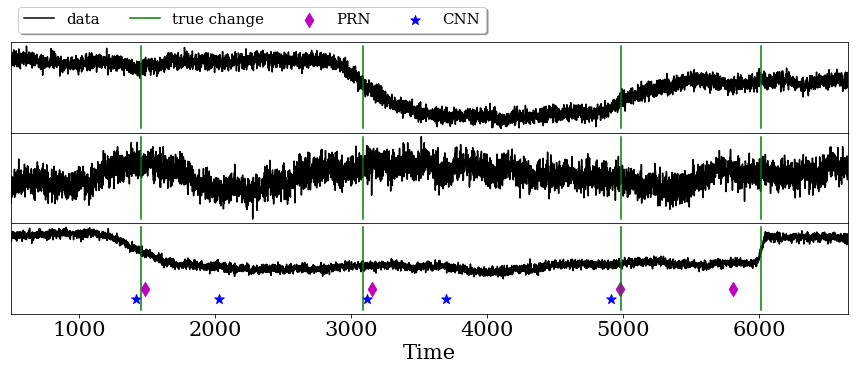

In [31]:
plot_timeseries(keys=['PRN', 'CNN'], var1=8, var2=5, var3=3, ts_idx=15, thresh=0.3)
plt.savefig('../plot/synth_sample.png', bbox_inches = 'tight')